# **1. Paths - Libs**

## **Paths**

In [61]:

# Dataset Path
DatasetPath = "E:/An toàn thông tin/Code/Dataset/NSL-KDD Processed/Final - For Using/"
train_dataset_path = DatasetPath + "Trainset/" + "IDS.csv"
test_dataset_path = DatasetPath + "Testset/" + "KDDTest+.csv"

# Save Model Path
SavedModelPath = "E:/An toàn thông tin/Code/Saved Model/IDSModel/"

##**Libs**

In [70]:
%run models.py

In [71]:
# IMPORT LIBS
import pandas as pd
import numpy as np
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from datetime import date

# Own Custom Module to import models and constants
from models import *
# from constants import *

# For draw Graphs
import matplotlib.pyplot as plt

# For create Folders
import os

In [72]:
%run models_gpu.py


In [73]:
import models_gpu

In [74]:
ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']
IDS_MODELS = {'DEFAULT': DefaultBlackboxIDS, 'SVM': SVM, 'MLP': MLP, 'LR': LR}

## **Consts**

#**2. Functions**

## **Processing Data Functions**

In [75]:
# Processing Data
# preprocess_data - Hàm tiền xử lý dữ liệu
def preprocess_data(dataset, attack_category):
    if attack_category not in ATTACK_CATEGORIES:
        raise ValueError("Preprocess Data: Invalid Attack Category")
    attack_data = dataset[dataset['class'] == attack_category]
    normal_data = dataset[dataset['class'] == 'Normal']
    # Combine Data
    combine_data = shuffle(pd.concat([attack_data, normal_data], ignore_index=True)).reset_index(drop=True)
    # Convert class to Binary
    combine_data["class"] = combine_data["class"].map(lambda x : 0 if x == "Normal" else 1)
    print(f"Amount of records: {combine_data.shape[0]}")
    print(f"Amount of {attack_category} Traffic: {attack_data.shape[0]}")
    print(f"Amount of Normal Traffic: {normal_data.shape[0]}")
    # separate data and label
    data, label = np.array(combine_data[combine_data.columns[combine_data.columns != "class"]]), np.array(combine_data["class"])
    return data, label

# load_dataset - Load du lieu voi Attack Category
def load_dataset(attack_category):
    if attack_category not in ATTACK_CATEGORIES:
        raise ValueError("Preprocess Data: Invalid Attack Category")
    # Load Dataset
    train = pd.read_csv(train_dataset_path)
    test = pd.read_csv(test_dataset_path)
    # Preprocess Data
    print("***TRAINSET***")
    trainx, trainy = preprocess_data(train, attack_category)
    print("***TESTSET***")
    testx, testy = preprocess_data(test, attack_category)
    return trainx, trainy, testx, testy

# create_batch1 - Hàm tạo Batch
def create_batch1(x,y,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    y = y[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:].tolist() for i in range(len(x)//batch_size)]
    batch_y = [y[batch_size * i : (i+1)*batch_size].tolist() for i in range(len(x)//batch_size)]
    return batch_x, batch_y 

In [76]:
%run constants.py

##IDS Functions

In [77]:
# IDS Functions
# Train - Train IDS
def Train(ids_model, data, label, batch_size, loss_f, opt):
    n_records = len(data)
    ids_model.train()
    batch_x, batch_y = create_batch1(data, label,batch_size)
    run_loss = 0
    for traffic,true_label in zip(batch_x,batch_y):
        ids_model.zero_grad()
        traffic = V(th.Tensor(traffic),requires_grad = True)
        true_label = V(th.LongTensor(true_label))
        out = ids_model(traffic)
        loss = loss_f(out,true_label)
        run_loss += loss.item()
        loss.backward()
        opt.step()
    return run_loss/n_records

# Test -Test IDS
def Test(ids_model, data, label, batch_size, loss_f, opt):
    n_records = len(data)
    ids_model.eval()
    batch_x, batch_y = create_batch1(data, label, batch_size)
    run_loss = 0
    correct = 0
    dr = []
    with th.no_grad():
        for traffic,true_label in zip(batch_x,batch_y):
            traffic = th.Tensor(traffic)
            true_label = th.LongTensor(true_label)
            out = ids_model(traffic) 
            # Calc Loss
            loss = loss_f(out,true_label)
            run_loss += loss.item()
            # Calc Accuracy, Detection Rate
            pred_label = th.argmax(nn.Sigmoid()(out),dim = 1).cpu().numpy()
            tn, fn, fp, tp = confusion_matrix(true_label,pred_label).ravel()
            # Accuracy
            correct = correct + tn + tp
            # Detection Rate
            dr.append(tp/(tp + fp))
    return (run_loss/n_records, 100*correct/n_records, 100*np.mean(dr))

# RunIDS - Chạy IDS: Train và Test
def RunIDS(ids_model_name = 'DEFAULT', attack_category = 'DOS', batch_size = 1024, max_epoch = 50):
    # CHECK MODEL NAME, ATTACK CATEGORY
    if attack_category not in ATTACK_CATEGORIES:
        raise ValueError("Load Dataset: Invalid Attack Category")
    if ids_model_name not in IDS_MODELS.keys():
        raise ValueError("Create IDS Model: Invalid Model Name")
    print("="*100)
    print(f"IDS MODEL: {ids_model_name}\n {99* '*'}\n ATTACK CATEGORY: {attack_category}")
    # LOAD DATASET
    print(f" {50*'-'}")
    trainx, trainy, testx, testy = load_dataset(attack_category)
    # CREATE MODEL
    BlackboxIDS = IDS_MODELS[ids_model_name]
    input_dim = trainx.shape[1]     # Number of dimension from dataset
    output_dim = 2                  # Label: Anomaly (1), Normaly (0)
    # Create BlackBoxIDS model
    ids_model = BlackboxIDS(input_dim,output_dim)
    # Loss  
    loss_f = nn.CrossEntropyLoss()
    # Optimizer 
    learning_rate = 0.001
    opt = optim.Adam(ids_model.parameters(),lr=learning_rate)

    # RUN MODEL 
    train_losses, test_losses = [],[]
    accuracies, drs = [],[]
    print(50*'-')
    print("---> IDS start training <---")
    print("Epoch \t\tTrain Loss \t\tTest Loss \t\tAccuracy \tDetection Rate(DR)")
    for epoch in range(max_epoch):
        train_loss = Train(ids_model, trainx, trainy, batch_size, loss_f, opt)
        test_loss, accuracy, dr = Test(ids_model, testx, testy, batch_size, loss_f, opt)
        accuracies.append(accuracy)
        drs.append(dr)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"{epoch+1:2d}: \t\t{train_loss:.6f} \t\t{test_loss:.6f} \t\t{accuracy:.2f}% \t\t{dr:.2f}%")
    print("IDS finished training")

    # SAVE GRAPH AND MODEL
    # Create Folder
    attack_category_path_4save_model = SavedModelPath + attack_category + '/'
    if not os.path.exists(attack_category_path_4save_model):
        os.makedirs(attack_category_path_4save_model)
    image_save_path = attack_category_path_4save_model + "images/"
    if not os.path.exists(image_save_path):
        os.makedirs(image_save_path)

    # Show Loss, Accuracy Graph
    # Loss Graph
    plt.plot(train_losses,label = "Train Loss")
    plt.plot(test_losses, label = "Test Loss")
    plt.legend()
    plt.savefig(image_save_path+ ids_model_name  +"_Loss.png")
    plt.show()
    # Accuracy, DR Graph
    plt.plot(accuracies, label = "Accuracy (%)")
    plt.plot(drs, label = "Detection Rate(%)")
    plt.legend()
    plt.show()

    # Save Model
    today = str(date.today())
    path = attack_category_path_4save_model + "Machine_Learning/created_date_" + today + "_" +  ids_model_name + ".pth"
    th.save(ids_model.state_dict(), path)
    print(f"IDS Model Saved Successfully at: {path}")

# **3. Chạy - Run**

In [78]:
ids_model_name = "LR" #@param ['SVM', 'MLP', 'LR']


IDS MODEL: LR
 ***************************************************************************************************
 ATTACK CATEGORY: DOS
 --------------------------------------------------
***TRAINSET***
Amount of records: 56634
Amount of DOS Traffic: 22963
Amount of Normal Traffic: 33671
***TESTSET***
Amount of records: 17171
Amount of DOS Traffic: 7460
Amount of Normal Traffic: 9711
--------------------------------------------------
---> IDS start training <---
Epoch 		Train Loss 		Test Loss 		Accuracy 	Detection Rate(DR)
 1: 		0.000544 		0.000491 		80.24% 		64.64%
 2: 		0.000415 		0.000418 		80.70% 		65.79%
 3: 		0.000332 		0.000377 		81.16% 		66.84%
 4: 		0.000277 		0.000353 		81.44% 		67.58%
 5: 		0.000239 		0.000337 		81.74% 		68.09%
 6: 		0.000212 		0.000330 		81.69% 		68.05%
 7: 		0.000192 		0.000324 		81.80% 		68.37%
 8: 		0.000176 		0.000321 		81.77% 		68.17%
 9: 		0.000164 		0.000321 		81.76% 		68.33%
10: 		0.000154 		0.000321 		81.83% 		68.54%
11: 		0.000146 		0.000320 		82

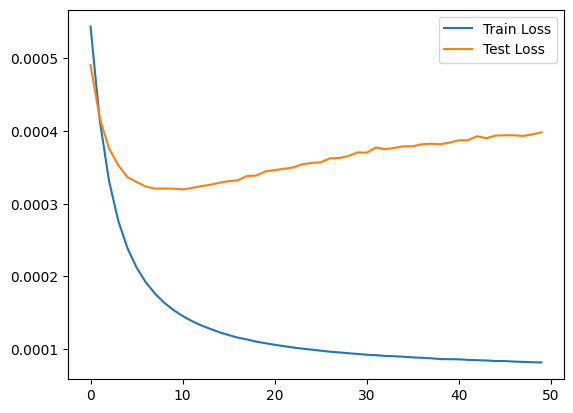

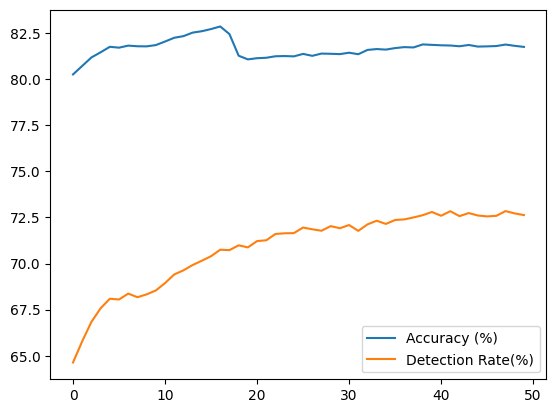

IDS Model Saved Successfully at: E:/An toàn thông tin/Code/Saved Model/IDSModel/DOS/Machine_Learning/created_date_2023-11-24_LR.pth
IDS MODEL: LR
 ***************************************************************************************************
 ATTACK CATEGORY: U2R_AND_R2L
 --------------------------------------------------
***TRAINSET***
Amount of records: 34194
Amount of U2R_AND_R2L Traffic: 523
Amount of Normal Traffic: 33671
***TESTSET***
Amount of records: 12663
Amount of U2R_AND_R2L Traffic: 2952
Amount of Normal Traffic: 9711
--------------------------------------------------
---> IDS start training <---
Epoch 		Train Loss 		Test Loss 		Accuracy 	Detection Rate(DR)
 1: 		0.000753 		0.000661 		51.98% 		36.29%
 2: 		0.000588 		0.000586 		74.93% 		5.65%
 3: 		0.000464 		0.000541 		74.48% 		0.03%
 4: 		0.000375 		0.000518 		74.48% 		0.00%
 5: 		0.000309 		0.000509 		74.40% 		0.00%
 6: 		0.000262 		0.000508 		74.45% 		0.00%
 7: 		0.000226 		0.000512 		74.45% 		0.00%
 8: 		0.000198

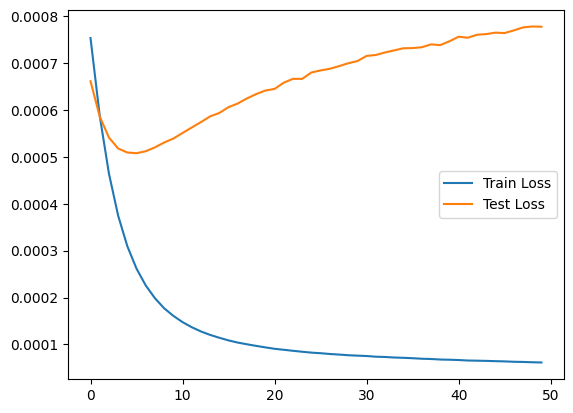

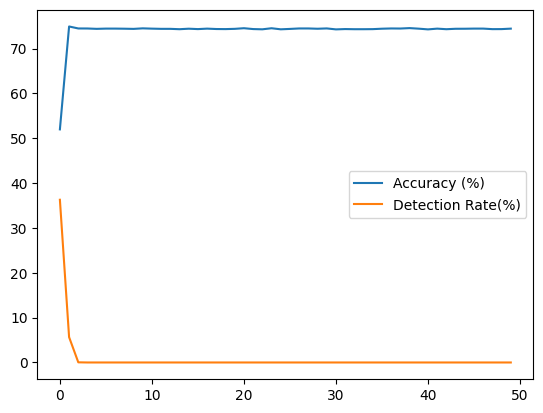

FileNotFoundError: [Errno 2] No such file or directory: 'E:/An toàn thông tin/Code/Saved Model/IDSModel/U2R_AND_R2L/Machine_Learning/created_date_2023-11-24_LR.pth'

In [79]:
for attack_category in ATTACK_CATEGORIES:
    RunIDS(ids_model_name, attack_category, batch_size = 1024, max_epoch = 50)

The Saved Model stored in [Google Drive - BlackBox IDS Model](https://drive.google.com/drive/u/1/folders/1M-xotvruMlkFNaQWPf9bpBpzgPhPLpiH)  
The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)